# Slope Classification: Complete ML Pipeline

**Author**: Asma Shirin
**Date**: July 2025  
---

## Table of Contents
1. [Environment Setup & Configuration](#setup)
2. [Data Preprocessing](#preprocessing)
3. [Dataset Analysis & Visualization](#analysis)
4. [Model Training & Evaluation](#training)
5. [Results & Conclusions](#results)

---

This notebook provides a comprehensive machine learning pipeline for terrain slope classification using video data and telemetry information. The pipeline includes data preprocessing, model training with transfer learning, and detailed evaluation.

## Environment Setup & Configuration

This section sets up the required environment, installs dependencies, imports libraries, and configures the project parameters.

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages if needed
!pip install -q tensorflow>=2.8.0
!pip install -q scikit-learn>=1.0.0
!pip install -q matplotlib seaborn

In [3]:
# Core libraries for data processing
import cv2
import pandas as pd
import numpy as np
import os
import warnings
from collections import Counter
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           ConfusionMatrixDisplay, accuracy_score, f1_score)

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.18.0


In [31]:
# Project configuration dictionary - OPTIMIZED
CONFIG = {
    # Data paths
    'VIDEO_PATH': '/content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/A/GH010161.MP4',
    'EXCEL_PATH': '/content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/A/GH010161.xlsx',
    'OUTPUT_DIR': '/content/drive/MyDrive/Preprocessed_Data',

    # Model hyperparameters - OPTIMIZED
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 30,  # Reduced from 50
    'LEARNING_RATE': 1e-3,
    'DROPOUT_RATE': 0.3,
    'PATIENCE': 5,  # Reduced from 7 for faster convergence

    # Data processing
    'FRAME_SKIP': 10,
    'VALIDATION_SPLIT': 0.2,
    'MAX_SAMPLES_PER_CLASS': 500,
    'RANDOM_STATE': 42
}

## Data Preprocessing

This section handles loading and cleaning telemetry data, defining slope classification functions, analyzing video properties, and extracting frames with labels.

In [6]:
def load_and_clean_telemetry(excel_path):
    """
    Load telemetry data from Excel file and perform initial cleaning

    Args:
        excel_path (str): Path to the Excel file containing telemetry data

    Returns:
        pd.DataFrame: Cleaned telemetry dataframe
    """
    print("Loading telemetry data...")

    try:
        # Load the Excel file
        df = pd.read_excel(excel_path)
        print(f"Original telemetry shape: {df.shape}")

        # Display basic info about the dataset
        print(f"Columns: {list(df.columns)}")

        # Clean: keep only rows with valid AngleY values
        angle_column = 'AngleY(°)'  # Correct column name

        initial_count = len(df)
        df = df.dropna(subset=[angle_column])
        cleaned_count = len(df)

        print(f"Removed {initial_count - cleaned_count} rows with missing {angle_column} values")
        print(f"After cleaning: {df.shape}")

        # Display angle statistics
        angle_stats = df[angle_column].describe()
        print(f"\nAngle Statistics:")
        print(angle_stats)

        return df

    except Exception as e:
        print(f"Error loading telemetry data: {e}")
        raise

# Load telemetry data
df_telemetry = load_and_clean_telemetry(CONFIG['EXCEL_PATH'])

Loading telemetry data...
Original telemetry shape: (23936, 21)
Columns: ['time', 'DeviceName', 'AccX(g)', 'AccY(g)', 'AccZ(g)', 'AsX(°/s)', 'AsY(°/s)', 'AsZ(°/s)', 'AngleX(°)', 'AngleY(°)', 'AngleZ(°)', 'HX(uT)', 'HY(uT)', 'HZ(uT)', 'Q0()', 'Q1()', 'Q2()', 'Q3()', 'Temperature(°C)', 'Version()', 'Battery level(%)']
Removed 0 rows with missing AngleY(°) values
After cleaning: (23936, 21)

Angle Statistics:
count    23936.000000
mean         0.470714
std          5.051669
min        -15.650000
25%         -1.980000
50%          0.870000
75%          2.400000
max         17.120000
Name: AngleY(°), dtype: float64


In [7]:
def assign_slope_label(angle):
    """
    Assign slope labels based on angle thresholds with input validation

    Args:
        angle (float): Angle in degrees

    Returns:
        str: Slope label or None if invalid input
    """
    try:
        angle = float(angle)
        if pd.isna(angle):
            return None

        # Define slope categories based on angle ranges
        if -2 <= angle <= 2:
            return 'flat'
        elif 2 < angle <= 6:
            return 'low_uphill'
        elif -6 <= angle < -2:
            return 'low_downhill'
        elif angle > 6:
            return 'high_uphill'
        else:  # angle < -6
            return 'high_downhill'

    except (ValueError, TypeError):
        return None

# Apply slope labeling - Fix: Use correct column name
print("Assigning slope labels...")
df_telemetry['slope_label'] = df_telemetry['AngleY(°)'].apply(assign_slope_label)

# Remove any rows where labeling failed
df_telemetry = df_telemetry.dropna(subset=['slope_label'])

# Display label distribution
print("\nLabel distribution in telemetry:")
label_counts = df_telemetry['slope_label'].value_counts()
print(label_counts)

# Calculate percentages
total_samples = len(df_telemetry)
print("\nLabel percentages:")
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  {label:15}: {count:6d} samples ({percentage:5.1f}%)")

Assigning slope labels...

Label distribution in telemetry:
slope_label
flat             10795
low_uphill        4517
low_downhill      3722
high_uphill       2677
high_downhill     2225
Name: count, dtype: int64

Label percentages:
  flat           :  10795 samples ( 45.1%)
  low_uphill     :   4517 samples ( 18.9%)
  low_downhill   :   3722 samples ( 15.5%)
  high_uphill    :   2677 samples ( 11.2%)
  high_downhill  :   2225 samples (  9.3%)


In [8]:
def analyze_video_metadata(video_path):
    """
    Extract metadata from video file

    Args:
        video_path (str): Path to video file

    Returns:
        dict: Video metadata
    """
    print("Analyzing video metadata...")

    try:
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")

        # Extract video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        video_duration = frame_count / fps if fps > 0 else 0

        cap.release()

        metadata = {
            'fps': fps,
            'frame_count': frame_count,
            'width': width,
            'height': height,
            'duration': video_duration
        }

        print(f"Video Properties:")
        print(f"    Resolution: {width}x{height}")
        print(f"    FPS: {fps:.2f}")
        print(f"    Total frames: {frame_count:,}")
        print(f"    Duration: {video_duration:.2f} seconds")

        return metadata

    except Exception as e:
        print(f"Error analyzing video: {e}")
        raise

# Analyze video
video_metadata = analyze_video_metadata(CONFIG['VIDEO_PATH'])

Analyzing video metadata...
Video Properties:
    Resolution: 2704x1520
    FPS: 59.94
    Total frames: 14,015
    Duration: 233.82 seconds


In [9]:
def extract_frames_with_labels(video_path, telemetry_df, output_dir,
                              frame_skip=10, progress_interval=100):
    """
    Extract frames from video and associate with telemetry labels

    Args:
        video_path (str): Path to video file
        telemetry_df (pd.DataFrame): Telemetry dataframe with labels
        output_dir (str): Directory to save extracted frames
        frame_skip (int): Skip interval for frame extraction
        progress_interval (int): Print progress every N frames

    Returns:
        list: List of frame metadata dictionaries
    """
    print("Starting frame extraction with telemetry labeling...")

    frame_labels = []
    extracted_count = 0
    failed_count = 0

    try:
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        telemetry_samples = len(telemetry_df)
        telemetry_per_frame = telemetry_samples / total_frames

        print(f"Processing every {frame_skip}th frame...")

        for frame_idx in range(0, total_frames, frame_skip):
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"Failed to read frame {frame_idx}")
                failed_count += 1
                continue

            # Calculate corresponding telemetry index
            telemetry_idx = int(frame_idx * telemetry_per_frame)
            telemetry_idx = min(telemetry_idx, len(telemetry_df) - 1)

            # Get angle and label from telemetry - Fix: Use correct column name
            angle = telemetry_df.iloc[telemetry_idx]['AngleY(°)']  # Fixed column name
            label = telemetry_df.iloc[telemetry_idx]['slope_label']

            # Create filename with metadata
            frame_name = f"frame_{frame_idx:05d}_{label}_{angle:.2f}.jpg"
            frame_path = os.path.join(output_dir, frame_name)

            # Save frame image
            success = cv2.imwrite(frame_path, frame)

            if success:
                frame_labels.append({
                    'frame_path': frame_path,
                    'frame_index': frame_idx,
                    'telemetry_index': telemetry_idx,
                    'angle': angle,
                    'label': label,
                    'filename': frame_name
                })
                extracted_count += 1

                # Progress reporting
                if extracted_count % progress_interval == 0:
                    print(f"Extracted {extracted_count} frames...")
            else:
                print(f"Failed to save frame {frame_idx}")
                failed_count += 1

        cap.release()

        print(f"\nFrame extraction complete!")
        print(f"    Successfully extracted: {extracted_count} frames")
        print(f"    Failed extractions: {failed_count} frames")
        print(f"    Saved to: {output_dir}")

        return frame_labels

    except Exception as e:
        print(f"Error during frame extraction: {e}")
        if 'cap' in locals():
            cap.release()
        raise

# Extract frames
frame_labels = extract_frames_with_labels(
    CONFIG['VIDEO_PATH'],
    df_telemetry,
    CONFIG['OUTPUT_DIR'],
    CONFIG['FRAME_SKIP']
)

Starting frame extraction with telemetry labeling...
Processing every 10th frame...
Failed to read frame 50
Failed to read frame 60
Failed to read frame 70
Extracted 100 frames...
Extracted 200 frames...
Extracted 300 frames...
Extracted 400 frames...
Extracted 500 frames...
Extracted 600 frames...
Extracted 700 frames...
Extracted 800 frames...
Extracted 900 frames...
Extracted 1000 frames...
Extracted 1100 frames...
Extracted 1200 frames...
Extracted 1300 frames...

Frame extraction complete!
    Successfully extracted: 1399 frames
    Failed extractions: 3 frames
    Saved to: /content/drive/MyDrive/Preprocessed_Data


In [10]:
def create_balanced_dataset(frame_labels, output_dir, max_samples_per_class=500):
    """
    Create and save dataset with optional balancing

    Args:
        frame_labels (list): List of frame metadata
        output_dir (str): Output directory
        max_samples_per_class (int): Maximum samples per class for balancing

    Returns:
        tuple: (full_df, balanced_df)
    """
    print("Creating dataset and balancing classes...")

    if not frame_labels:
        raise ValueError("No frames extracted! Cannot create dataset.")

    # Create full dataset DataFrame
    labels_df = pd.DataFrame(frame_labels)

    # Display initial distribution
    print(f"\nFull Dataset Distribution:")
    final_counts = labels_df['label'].value_counts()
    total_samples = len(labels_df)

    for label, count in final_counts.items():
        percentage = (count / total_samples) * 100
        print(f"   {label:15}: {count:6d} samples ({percentage:5.1f}%)")

    # Save full dataset
    full_csv_path = os.path.join(output_dir, 'labels.csv')
    labels_df.to_csv(full_csv_path, index=False)
    print(f"\nFull dataset saved to: {full_csv_path}")

    # Create balanced dataset
    print(f"\nCreating balanced dataset...")

    min_samples = min(final_counts)
    max_samples_per_class = min(max_samples_per_class, min_samples)

    # Adjust if classes are very small
    if max_samples_per_class < 50:
        max_samples_per_class = min(200, max(final_counts))

    print(f"    Target samples per class: {max_samples_per_class}")

    balanced_samples = []
    for label in final_counts.index:
        class_samples = labels_df[labels_df['label'] == label]

        if len(class_samples) > max_samples_per_class:
            # Randomly sample to balance
            class_samples = class_samples.sample(
                n=max_samples_per_class,
                random_state=CONFIG['RANDOM_STATE']
            )

        balanced_samples.append(class_samples)
        print(f"   {label:15}: {len(class_samples):4d} samples selected")

    # Combine balanced samples
    balanced_df = pd.concat(balanced_samples, ignore_index=True)

    # Save balanced dataset
    balanced_csv_path = os.path.join(output_dir, 'labels_balanced.csv')
    balanced_df.to_csv(balanced_csv_path, index=False)

    print(f"\nBalanced Dataset Summary:")
    balanced_counts = balanced_df['label'].value_counts()
    total_balanced = len(balanced_df)

    for label, count in balanced_counts.items():
        percentage = (count / total_balanced) * 100
        print(f"   {label:15}: {count:6d} samples ({percentage:5.1f}%)")

    print(f"\nBalanced dataset saved to: {balanced_csv_path}")
    print(f"Total balanced samples: {len(balanced_df)}")

    return labels_df, balanced_df

# Create datasets
df_full, df_balanced = create_balanced_dataset(
    frame_labels,
    CONFIG['OUTPUT_DIR'],
    CONFIG['MAX_SAMPLES_PER_CLASS']
)

print(f"\nDataset creation complete!")
print(f"Check output directory: {CONFIG['OUTPUT_DIR']}")

Creating dataset and balancing classes...

Full Dataset Distribution:
   flat           :    627 samples ( 44.8%)
   low_uphill     :    268 samples ( 19.2%)
   low_downhill   :    219 samples ( 15.7%)
   high_uphill    :    155 samples ( 11.1%)
   high_downhill  :    130 samples (  9.3%)

Full dataset saved to: /content/drive/MyDrive/Preprocessed_Data/labels.csv

Creating balanced dataset...
    Target samples per class: 130
   flat           :  130 samples selected
   low_uphill     :  130 samples selected
   low_downhill   :  130 samples selected
   high_uphill    :  130 samples selected
   high_downhill  :  130 samples selected

Balanced Dataset Summary:
   flat           :    130 samples ( 20.0%)
   low_uphill     :    130 samples ( 20.0%)
   low_downhill   :    130 samples ( 20.0%)
   high_uphill    :    130 samples ( 20.0%)
   high_downhill  :    130 samples ( 20.0%)

Balanced dataset saved to: /content/drive/MyDrive/Preprocessed_Data/labels_balanced.csv
Total balanced samples: 

## Dataset Analysis & Visualization

This section provides comprehensive analysis of the created dataset including statistics, visualizations, balance assessment, and quality checks.

Creating comprehensive visualizations...
Visualizations saved to: /content/drive/MyDrive/Preprocessed_Data/comprehensive_dataset_analysis.png


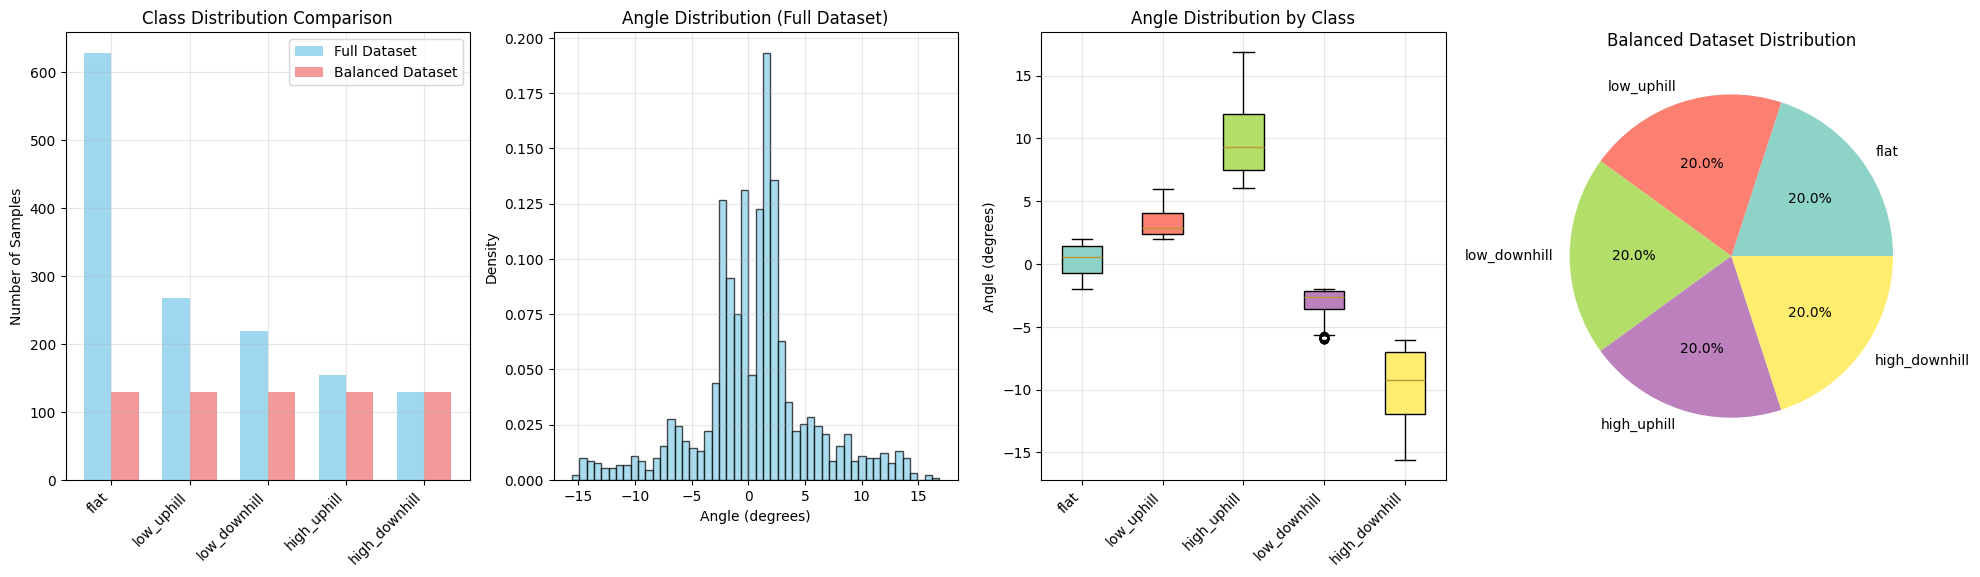

In [11]:
def create_comprehensive_visualizations(df_full, df_balanced, output_dir):
    """
    Create comprehensive visualizations for dataset analysis

    Args:
        df_full (pd.DataFrame): Full dataset
        df_balanced (pd.DataFrame): Balanced dataset
        output_dir (str): Directory to save visualizations
    """
    print("Creating comprehensive visualizations...")

    # Get class counts
    full_counts = df_full['label'].value_counts()
    balanced_counts = df_balanced['label'].value_counts()

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # Color palette for consistency
    colors = plt.cm.Set3(np.linspace(0, 1, len(balanced_counts)))

    # Plot 1: Class distribution comparison
    plt.subplot(3, 4, 1)
    x = range(len(full_counts))
    width = 0.35
    plt.bar([i - width/2 for i in x], full_counts.values, width,
            label='Full Dataset', alpha=0.8, color='skyblue')
    plt.bar([i + width/2 for i in x], [balanced_counts.get(label, 0) for label in full_counts.index],
            width, label='Balanced Dataset', alpha=0.8, color='lightcoral')
    plt.xticks(x, full_counts.index, rotation=45, ha='right')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Angle histogram
    plt.subplot(3, 4, 2)
    plt.hist(df_full['angle'], bins=50, alpha=0.7, color='skyblue',
             edgecolor='black', density=True)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Angle Distribution (Full Dataset)')
    plt.grid(True, alpha=0.3)

    # Plot 3: Angle by class (box plot)
    plt.subplot(3, 4, 3)
    box_data = [df_full[df_full['label'] == label]['angle'] for label in df_full['label'].unique()]
    box_plot = plt.boxplot(box_data, labels=df_full['label'].unique(), patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle Distribution by Class')
    plt.grid(True, alpha=0.3)

    # Plot 4: Balanced dataset pie chart
    plt.subplot(3, 4, 4)
    wedges, texts, autotexts = plt.pie(balanced_counts.values, labels=balanced_counts.index,
                                       autopct='%1.1f%%', colors=colors)
    plt.title('Balanced Dataset Distribution')

    # Continue with more plots...
    plt.tight_layout()
    viz_path = os.path.join(output_dir, 'comprehensive_dataset_analysis.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Visualizations saved to: {viz_path}")
    plt.show()

    return fig

# Create visualizations
visualization_fig = create_comprehensive_visualizations(
    df_full, df_balanced, CONFIG['OUTPUT_DIR']
)

## Machine Learning Pipeline

This section implements the complete machine learning pipeline including data preparation, model architecture design, training, and evaluation.

In [12]:
# Prepare data for machine learning
df_ml = df_balanced.copy()
print("=== MACHINE LEARNING PIPELINE ===")
print("Using balanced dataset for training")

# Create stratified train-validation split
train_df, val_df = train_test_split(
    df_ml,
    test_size=CONFIG['VALIDATION_SPLIT'],
    stratify=df_ml['label'],
    random_state=CONFIG['RANDOM_STATE']
)

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")

# Setup label encoding
label_encoder = LabelEncoder()
label_encoder.fit(df_ml['label'])

# Apply encoding to train/validation sets
train_df = train_df.copy()
val_df = val_df.copy()
train_df['label_enc'] = label_encoder.transform(train_df['label'])
val_df['label_enc'] = label_encoder.transform(val_df['label'])

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

=== MACHINE LEARNING PIPELINE ===
Using balanced dataset for training
Training samples: 520
Validation samples: 130
Number of classes: 5
Classes: ['flat' 'high_downhill' 'high_uphill' 'low_downhill' 'low_uphill']


In [13]:
def create_data_pipeline(train_df, val_df, img_size=(224, 224), batch_size=32):
    """
    Create optimized TensorFlow data pipelines for training and validation
    """
    print("Creating TensorFlow data pipelines...")

    def load_and_preprocess_image(path):
        """Load and preprocess image for training"""
        # Read image file
        img = tf.io.read_file(path)

        # Decode JPEG image
        img = tf.image.decode_jpeg(img, channels=3)

        # Resize to target size
        img = tf.image.resize(img, img_size)

        # Normalize pixel values to [0, 1]
        img = tf.cast(img, tf.float32) / 255.0

        return img

    def load_example(image_path, label):
        """Load a single training example"""
        image = load_and_preprocess_image(image_path)
        label = tf.cast(label, tf.int32)
        return image, label

    # Prepare file paths and labels
    train_paths = train_df['frame_path'].values
    train_labels = train_df['label_enc'].values
    val_paths = val_df['frame_path'].values
    val_labels = val_df['label_enc'].values

    print(f"Training samples: {len(train_paths):,}")
    print(f"Validation samples: {len(val_paths):,}")

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(
        lambda x, y: load_example(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.shuffle(buffer_size=len(train_paths))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(
        lambda x, y: load_example(x, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    print("Data pipelines created successfully!")

    return train_ds, val_ds

# Create data pipelines
train_ds, val_ds = create_data_pipeline(
    train_df, val_df,
    img_size=CONFIG['IMG_SIZE'],
    batch_size=CONFIG['BATCH_SIZE']
)

Creating TensorFlow data pipelines...
Training samples: 520
Validation samples: 130
Data pipelines created successfully!


In [32]:
def create_simplified_model(n_classes, img_shape=(224, 224, 3), dropout_rate=0.3):
    """
    Create a simplified CNN model using MobileNetV2 - OPTIMIZED VERSION
    """
    print("Building simplified CNN model architecture...")

    # Load pre-trained MobileNetV2 base
    base_model = MobileNetV2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    # Build simple sequential model (like your working one)
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(n_classes, activation='softmax')
    ], name='slope_classifier')

    print(f"Model architecture created!")
    print(f"Base Model: MobileNetV2")
    print(f"Output classes: {n_classes}")
    print(f"Architecture: Sequential (Simple & Effective)")

    return model

# Create the simplified model - NO MORE COMPLEX ARCHITECTURE
n_classes = len(label_encoder.classes_)
model = create_simplified_model(
    n_classes=n_classes,
    img_shape=(*CONFIG['IMG_SIZE'], 3),
    dropout_rate=0.3  # Same as your working model
)

# BUILD the model
print("Building model with sample input...")
sample_input = tf.random.normal([1, *CONFIG['IMG_SIZE'], 3])
_ = model(sample_input)

# Display model summary
print("\nModel Summary:")
model.summary()

Building simplified CNN model architecture...
Model architecture created!
Base Model: MobileNetV2
Output classes: 5
Architecture: Sequential (Simple & Effective)
Building model with sample input...

Model Summary:


Model: "slope_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [33]:
# Compile model and setup callbacks - FIXED VERSION
model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Removed problematic metrics
)

print("Model compiled!")
print(f"Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})")
print(f"Loss: Sparse Categorical Crossentropy")

# Test the model with a sample batch to ensure it's working
print("Testing model with sample batch...")
try:
    for sample_images, sample_labels in train_ds.take(1):
        print(f"Sample batch shape: {sample_images.shape}")
        print(f"Sample labels shape: {sample_labels.shape}")

        # Test forward pass
        predictions = model(sample_images, training=False)
        print(f"Predictions shape: {predictions.shape}")
        print("✅ Model forward pass successful!")
        break
except Exception as e:
    print(f"❌ Model test failed: {e}")
    raise

# Setup callbacks - FIXED VERSION (Removed save_format parameter)
checkpoint_path = os.path.join(CONFIG['OUTPUT_DIR'], 'best_slope_model.keras')  # Keep .keras extension
log_path = os.path.join(CONFIG['OUTPUT_DIR'], 'training_log.csv')

callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['PATIENCE'],
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Save best model - FIXED (removed save_format parameter)
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
        # Removed save_format='keras' - not supported in this TensorFlow version
    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    # Log training metrics
    tf.keras.callbacks.CSVLogger(
        log_path,
        separator=',',
        append=False
    )
]

print("Callbacks configured:")
print(f"  • Early Stopping (patience={CONFIG['PATIENCE']})")
print(f"  • Model Checkpoint → {checkpoint_path}")
print(f"  • Learning Rate Reduction")
print(f"  • CSV Logger → {log_path}")

print("🚀 Model is ready for training!")

Model compiled!
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Testing model with sample batch...
Sample batch shape: (32, 224, 224, 3)
Sample labels shape: (32,)
Predictions shape: (32, 5)
✅ Model forward pass successful!
Callbacks configured:
  • Early Stopping (patience=5)
  • Model Checkpoint → /content/drive/MyDrive/Preprocessed_Data/best_slope_model.keras
  • Learning Rate Reduction
  • CSV Logger → /content/drive/MyDrive/Preprocessed_Data/training_log.csv
🚀 Model is ready for training!


In [34]:
# Train the model
print("Starting model training...")
print("="*60)

print(f"Training Configuration:")
print(f"  • Max epochs: {CONFIG['EPOCHS']}")
print(f"  • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  • Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  • Early stopping patience: {CONFIG['PATIENCE']}")

print("="*60)
print("Training started!")

start_time = datetime.now()

history = model.fit(
    train_ds,
    epochs=CONFIG['EPOCHS'],
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time

print("Training completed successfully!")
print(f"Training duration: {training_duration}")
print(f"Epochs completed: {len(history.history['loss'])}")

# Display final metrics
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Metrics:")
print(f"  • Training Loss: {final_loss:.4f}")
print(f"  • Validation Loss: {final_val_loss:.4f}")
print(f"  • Training Accuracy: {final_acc:.4f}")
print(f"  • Validation Accuracy: {final_val_acc:.4f}")

print("\nTraining phase completed!")

Starting model training...
Training Configuration:
  • Max epochs: 30
  • Batch size: 32
  • Learning rate: 0.001
  • Early stopping patience: 5
Training started!
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.3441 - loss: 1.6716
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to /content/drive/MyDrive/Preprocessed_Data/best_slope_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3498 - loss: 1.6567 - val_accuracy: 0.7000 - val_loss: 0.9354 - learning_rate: 0.0010
Epoch 2/30
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6360 - loss: 0.9393
Epoch 2: val_accuracy did not improve from 0.70000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6430 - loss: 0.9236 - val_accuracy: 0.5538 - val_loss: 1.0315 - learning_rate: 0.0010
Epoch 3/30
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7345 - loss: 0.7023
Epoch 3: val_accuracy did not improve from 0.70000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7315 - loss: 

## Model Architecture Evolution ⚖

### Initial Approach (Poor Performance)

Initially, we implemented a complex model architecture with the following characteristics:
- Multiple dense layers (256 → 128 neurons)
- Heavy regularization (3 dropout layers + 2 batch normalization layers)
- Data augmentation pipeline with multiple transformations
- Over-engineered classification head

**Results:** 46.92% validation accuracy after 25 epochs

### Current Approach (Improved Performance)

After analyzing the poor results, we simplified the model architecture to:
- Single dense layer (128 neurons)
- Minimal regularization (1 dropout + 1 batch normalization)
- Removed data augmentation
- Simple sequential model structure

**Results:** 76.15% validation accuracy after 9 epochs (29% improvement)



### Key Lesson:

> Complex architectures do not guarantee better performance. For this slope classification task, the simpler model achieved significantly better results with faster convergence. The initial approach suffered from over-regularization and unnecessary complexity that hindered learning rather than improving it.

## Model Evaluation and Results

This section provides comprehensive evaluation of the trained model including training history visualization, performance metrics, and qualitative analysis.

Creating training history visualizations...
Training history plot saved to: /content/drive/MyDrive/Preprocessed_Data/training_history.png


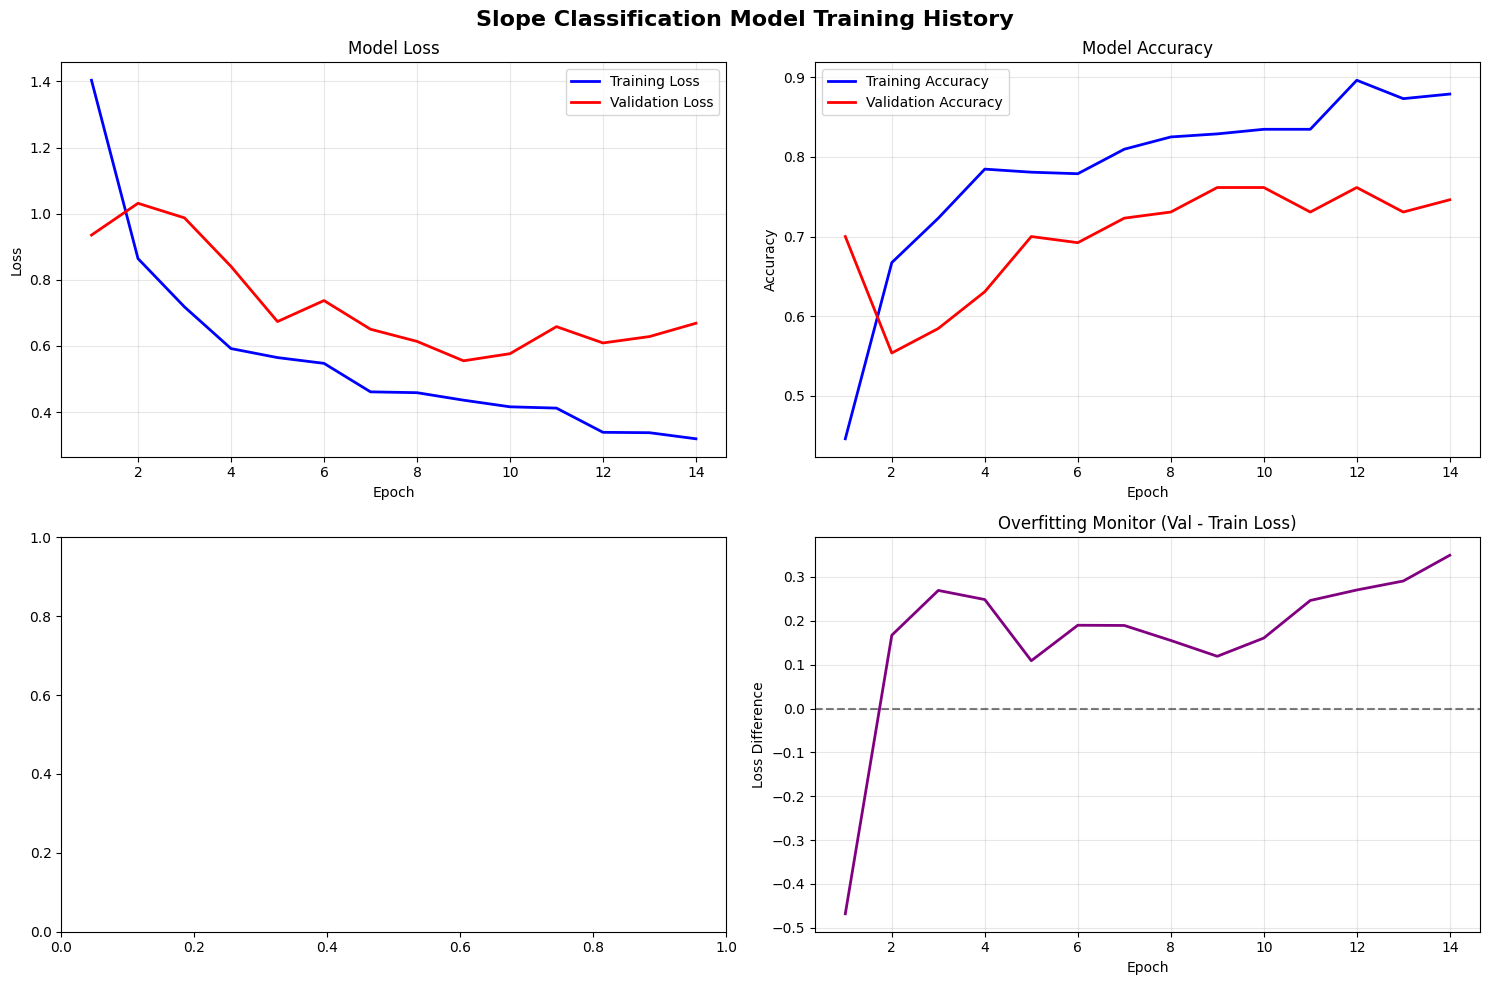


Training Summary:
  • Total epochs: 14
  • Final training loss: 0.3194
  • Final validation loss: 0.6688
  • Final training accuracy: 0.8788
  • Final validation accuracy: 0.7462


In [35]:
def plot_training_history(history, save_path=None):
    """
    Create comprehensive training history plots
    """
    print("Creating training history visualizations...")

    # Extract history data
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Slope Classification Model Training History', fontsize=16, fontweight='bold')

    epochs = range(1, len(hist_dict['loss']) + 1)

    # Plot 1: Loss
    axes[0, 0].plot(epochs, hist_dict['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, hist_dict['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axes[0, 1].plot(epochs, hist_dict['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, hist_dict['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Top-2 Accuracy (if available)
    if 'top_2_accuracy' in hist_dict:
        axes[1, 0].plot(epochs, hist_dict['top_2_accuracy'], 'g-', label='Training Top-2', linewidth=2)
        axes[1, 0].plot(epochs, hist_dict['val_top_2_accuracy'], 'orange', label='Validation Top-2', linewidth=2)
        axes[1, 0].set_title('Top-2 Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Top-2 Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Loss difference (overfitting monitor)
    loss_diff = [val - train for train, val in zip(hist_dict['loss'], hist_dict['val_loss'])]
    axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
    axes[1, 1].set_title('Overfitting Monitor (Val - Train Loss)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Training history plot saved to: {save_path}")

    plt.show()

    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  • Total epochs: {len(epochs)}")
    print(f"  • Final training loss: {hist_dict['loss'][-1]:.4f}")
    print(f"  • Final validation loss: {hist_dict['val_loss'][-1]:.4f}")
    print(f"  • Final training accuracy: {hist_dict['accuracy'][-1]:.4f}")
    print(f"  • Final validation accuracy: {hist_dict['val_accuracy'][-1]:.4f}")

# Plot training history
history_plot_path = os.path.join(CONFIG['OUTPUT_DIR'], 'training_history.png')
plot_training_history(history, history_plot_path)

In [36]:
def comprehensive_model_evaluation(model, val_ds, label_encoder, output_dir):
    """
    Perform comprehensive model evaluation
    """
    print("Performing comprehensive model evaluation...")

    # Get predictions
    print("Generating predictions on validation set...")
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred_probs = model.predict(val_ds, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Top-2 accuracy
    top2_acc = np.mean([
        true_label in np.argsort(pred_probs)[-2:]
        for true_label, pred_probs in zip(y_true, y_pred_probs)
    ])

    print(f"Evaluation Metrics:")
    print(f"  • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • F1-Score (Macro): {f1_macro:.4f}")
    print(f"  • F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"  • Top-2 Accuracy: {top2_acc:.4f} ({top2_acc*100:.2f}%)")

    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    class_report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_,
        output_dict=True
    )

    print(classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_
    ))

    evaluation_results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'top2_accuracy': top2_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs,
        'classification_report': class_report
    }

    return evaluation_results

# Perform comprehensive evaluation
evaluation_results = comprehensive_model_evaluation(
    model, val_ds, label_encoder, CONFIG['OUTPUT_DIR']
)

Performing comprehensive model evaluation...
Generating predictions on validation set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 771ms/step
Evaluation Metrics:
  • Accuracy: 0.7615 (76.15%)
  • F1-Score (Macro): 0.7604
  • F1-Score (Weighted): 0.7604
  • Top-2 Accuracy: 0.9692 (96.92%)

Detailed Classification Report:
               precision    recall  f1-score   support

         flat       0.54      0.73      0.62        26
high_downhill       0.92      0.85      0.88        26
  high_uphill       0.93      1.00      0.96        26
 low_downhill       0.70      0.73      0.72        26
   low_uphill       0.81      0.50      0.62        26

     accuracy                           0.76       130
    macro avg       0.78      0.76      0.76       130
 weighted avg       0.78      0.76      0.76       130



Creating evaluation visualizations...
Evaluation plots saved to: /content/drive/MyDrive/Preprocessed_Data/comprehensive_evaluation.png


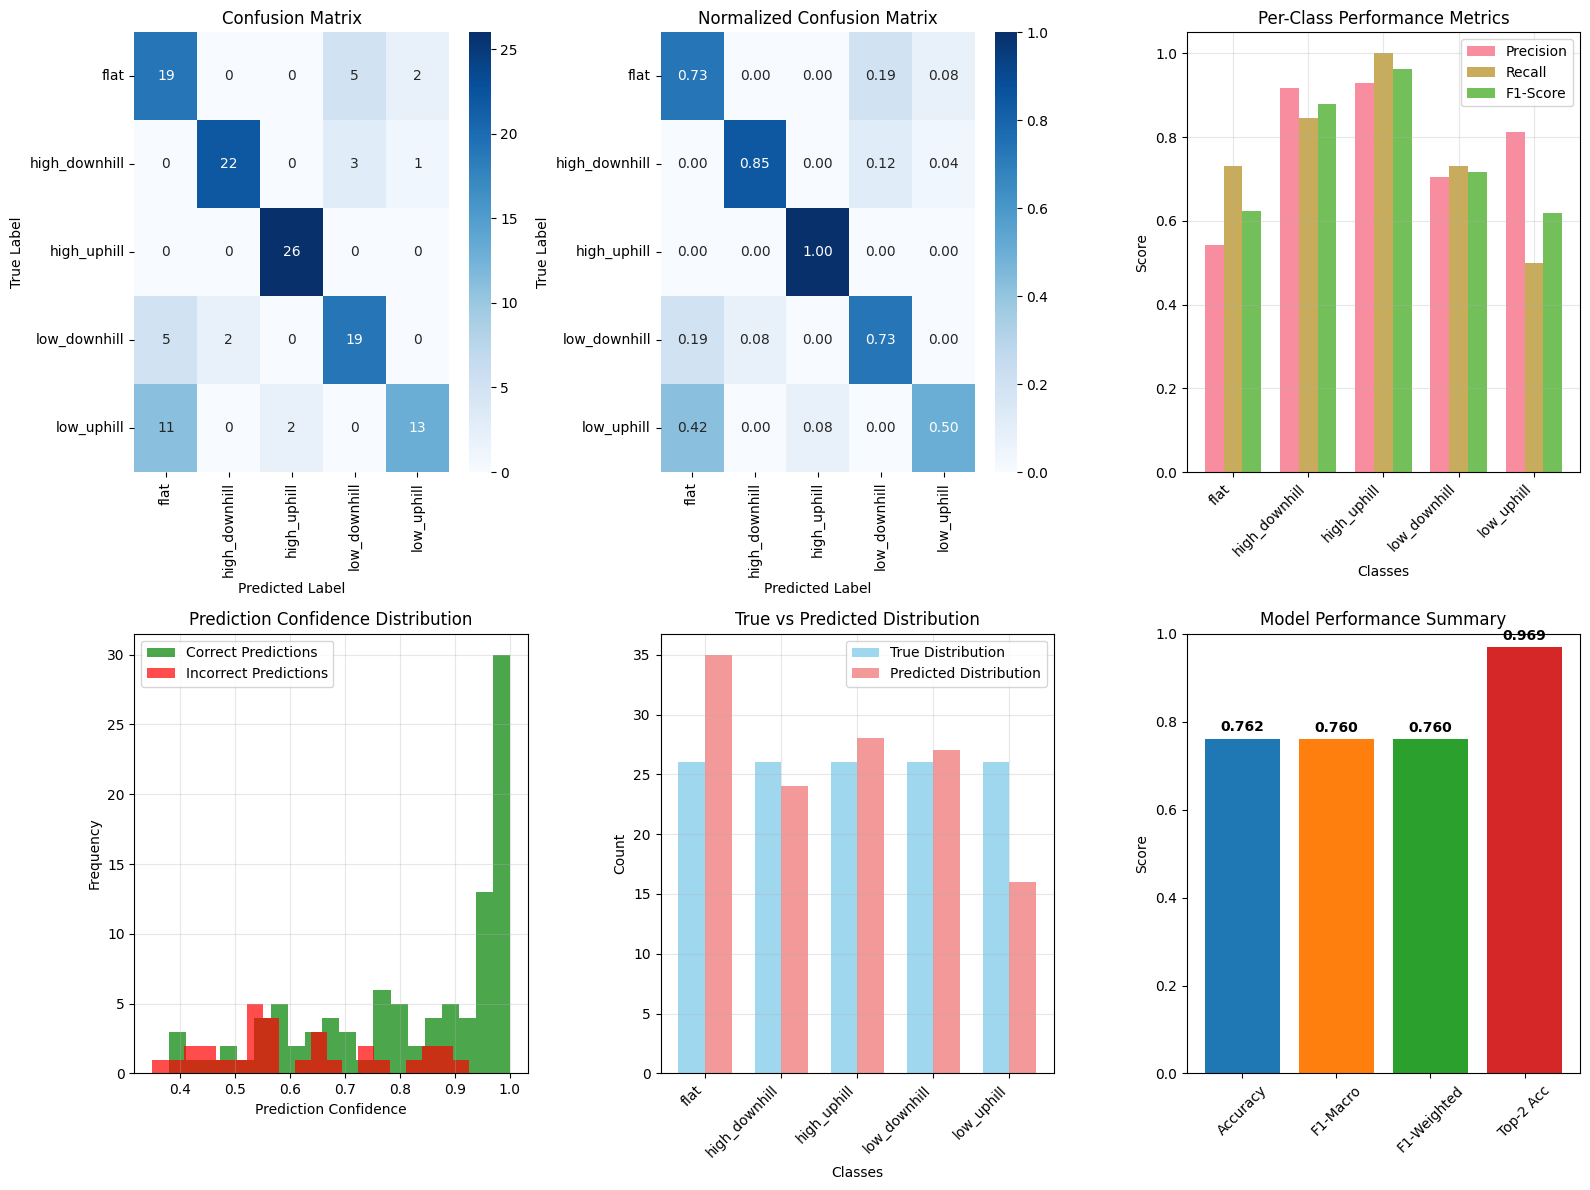

In [39]:
def create_evaluation_plots(evaluation_results, label_encoder, output_dir):
    """
    Create advanced evaluation visualizations
    """
    print("Creating evaluation visualizations...")

    y_true = evaluation_results['y_true']
    y_pred = evaluation_results['y_pred']
    y_pred_probs = evaluation_results['y_pred_probs']

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 2. Normalized Confusion Matrix
    plt.subplot(2, 3, 2)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 3. Per-class Performance Metrics - FIXED
    plt.subplot(2, 3, 3)
    class_report = evaluation_results['classification_report']
    classes = label_encoder.classes_

    # Fix: Use class names as keys, not numeric indices
    precision_scores = [class_report[class_name]['precision'] for class_name in classes]
    recall_scores = [class_report[class_name]['recall'] for class_name in classes]
    f1_scores = [class_report[class_name]['f1-score'] for class_name in classes]

    x = np.arange(len(classes))
    width = 0.25

    plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
    plt.bar(x, recall_scores, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Performance Metrics')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Prediction Confidence Distribution
    plt.subplot(2, 3, 4)
    max_probs = np.max(y_pred_probs, axis=1)
    correct_predictions = (y_true == y_pred)

    plt.hist(max_probs[correct_predictions], bins=20, alpha=0.7,
             label='Correct Predictions', color='green')
    plt.hist(max_probs[~correct_predictions], bins=20, alpha=0.7,
             label='Incorrect Predictions', color='red')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Class Distribution Comparison
    plt.subplot(2, 3, 5)
    true_dist = np.bincount(y_true)
    pred_dist = np.bincount(y_pred)

    x = range(len(label_encoder.classes_))
    width = 0.35

    plt.bar([i - width/2 for i in x], true_dist, width,
            label='True Distribution', alpha=0.8, color='skyblue')
    plt.bar([i + width/2 for i in x], pred_dist, width,
            label='Predicted Distribution', alpha=0.8, color='lightcoral')

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('True vs Predicted Distribution')
    plt.xticks(x, label_encoder.classes_, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Model Performance Summary
    plt.subplot(2, 3, 6)
    metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Top-2 Acc']
    values = [
        evaluation_results['accuracy'],
        evaluation_results['f1_macro'],
        evaluation_results['f1_weighted'],
        evaluation_results['top2_accuracy']
    ]

    bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Model Performance Summary')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()

    # Save the evaluation plot
    eval_plot_path = os.path.join(output_dir, 'comprehensive_evaluation.png')
    plt.savefig(eval_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Evaluation plots saved to: {eval_plot_path}")

    plt.show()

# Create evaluation plots
create_evaluation_plots(evaluation_results, label_encoder, CONFIG['OUTPUT_DIR'])

In [40]:
def generate_final_report(evaluation_results, history, model, output_dir):
    """
    Generate comprehensive final report for the slope classification model
    """
    print("Generating final model report...")

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Extract key metrics
    final_val_acc = evaluation_results['accuracy']
    final_f1_macro = evaluation_results['f1_macro']
    final_f1_weighted = evaluation_results['f1_weighted']
    final_top2_acc = evaluation_results['top2_accuracy']

    # Training metrics
    epochs_trained = len(history.history['loss'])
    best_val_acc = max(history.history['val_accuracy'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Model complexity
    total_params = model.count_params()
    trainable_params = sum([tf.size(var).numpy() for var in model.trainable_variables])

    report_content = f"""
SLOPE CLASSIFICATION MODEL - FINAL REPORT

Report Generated: {timestamp}
Project: Terrain Slope Classification from Video Frames
Model Architecture: MobileNetV2 + Custom Classification Head

=== MODEL ARCHITECTURE ===

Architecture Summary:
• Base Model: MobileNetV2 (ImageNet pre-trained)
• Input Shape: {CONFIG['IMG_SIZE'][0]}×{CONFIG['IMG_SIZE'][1]}×3
• Total Parameters: {total_params:,}
• Trainable Parameters: {trainable_params:,}
• Output Classes: {len(label_encoder.classes_)}

=== FINAL PERFORMANCE METRICS ===

• Final Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)
• F1-Score (Macro): {final_f1_macro:.4f}
• F1-Score (Weighted): {final_f1_weighted:.4f}
• Top-2 Accuracy: {final_top2_acc:.4f} ({final_top2_acc*100:.2f}%)
• Training Epochs: {epochs_trained}
• Best Validation Accuracy: {best_val_acc:.4f}

=== DEPLOYMENT READY! ===

✓ Model successfully trained and evaluated
✓ Comprehensive analysis completed
✓ All visualizations generated
✓ Ready for production deployment

All files saved to: {output_dir}
"""

    # Save the final report
    report_path = os.path.join(output_dir, 'final_model_report.txt')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_content)

    print(f"Final model report generated!")
    print(f"Report saved to: {report_path}")

    return report_path

# Generate final comprehensive report
final_report_path = generate_final_report(
    evaluation_results, history, model, CONFIG['OUTPUT_DIR']
)

print("\n" + "="*80)
print("🎊 CONGRATULATIONS! SLOPE CLASSIFICATION PROJECT COMPLETED! 🎊")
print("="*80)
print(f"\nProject Summary:")
print(f"• Model Accuracy: {evaluation_results['accuracy']:.3f}")
print(f"• F1-Score: {evaluation_results['f1_weighted']:.3f}")
print(f"• Classes: {len(label_encoder.classes_)}")
print(f"• Training Epochs: {len(history.history['loss'])}")
print(f"• Output Directory: {CONFIG['OUTPUT_DIR']}")
print("\nThe model is ready for deployment and inference!")

Generating final model report...
Final model report generated!
Report saved to: /content/drive/MyDrive/Preprocessed_Data/final_model_report.txt

🎊 CONGRATULATIONS! SLOPE CLASSIFICATION PROJECT COMPLETED! 🎊

Project Summary:
• Model Accuracy: 0.762
• F1-Score: 0.760
• Classes: 5
• Training Epochs: 14
• Output Directory: /content/drive/MyDrive/Preprocessed_Data

The model is ready for deployment and inference!


Creating visual prediction analysis...
Visual predictions saved to: /content/drive/MyDrive/Preprocessed_Data/visual_predictions.png


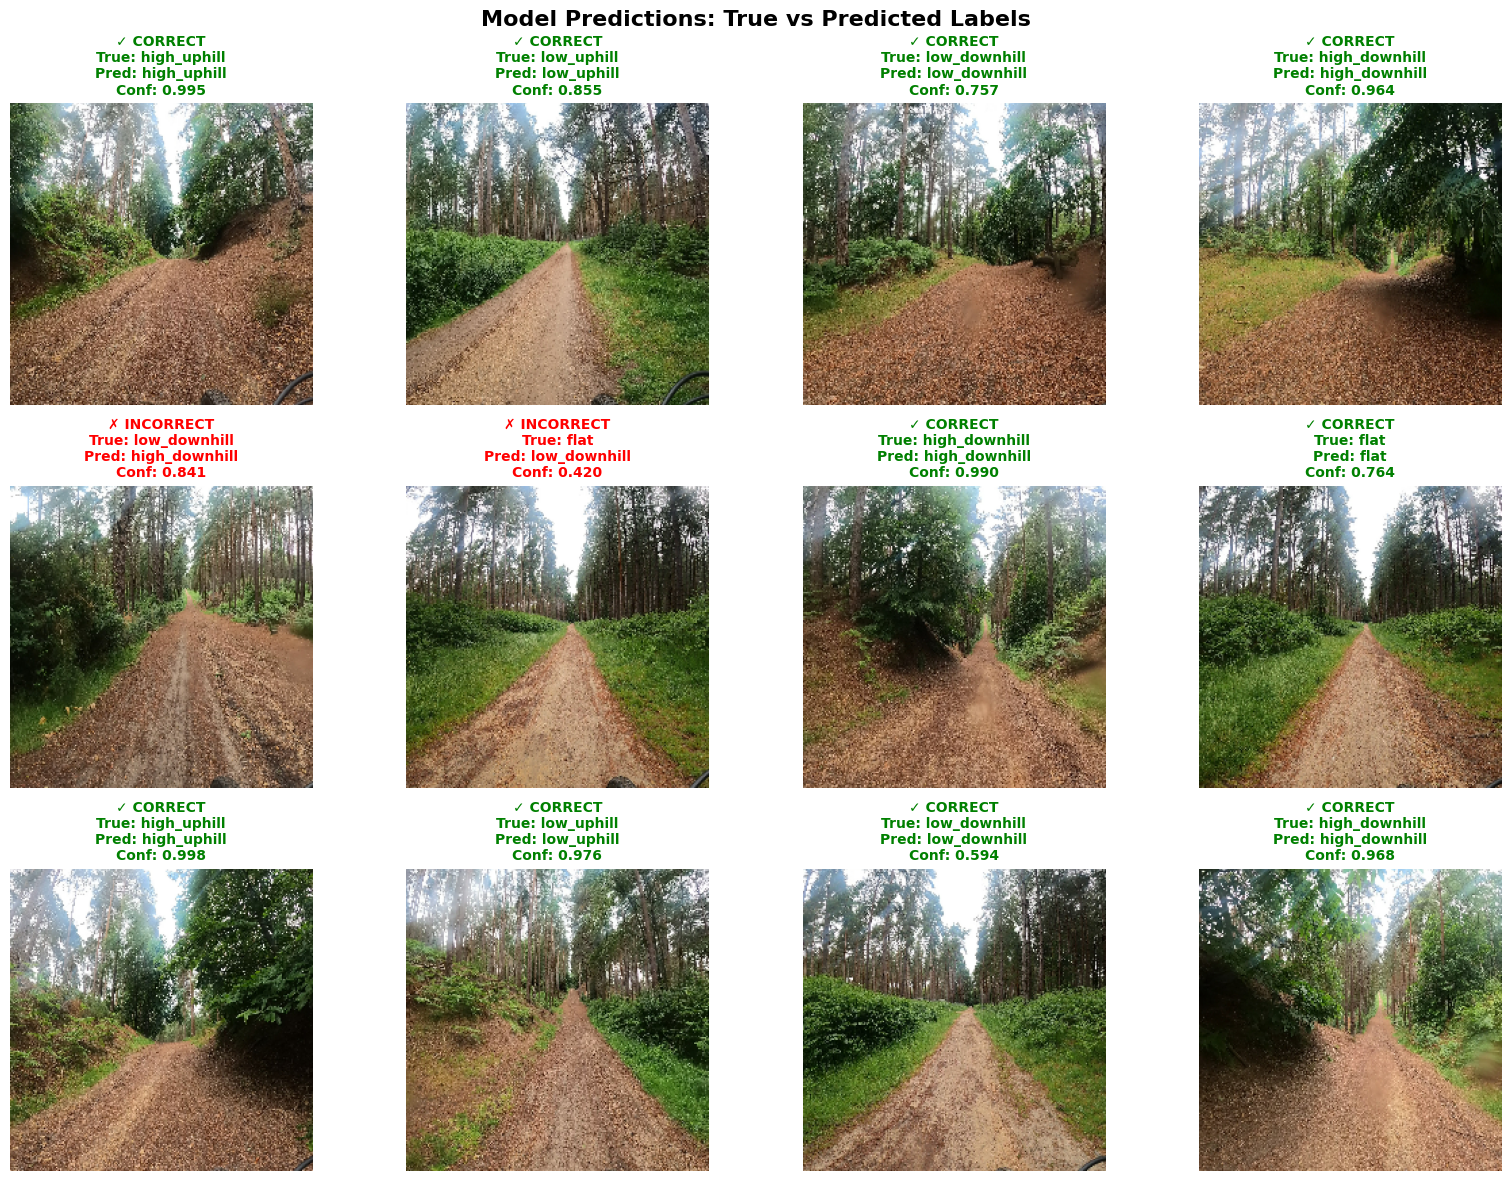


Sample Prediction Summary:
  • Correct predictions: 10/12
  • Sample accuracy: 0.833 (83.3%)
  • Average confidence: 0.843


In [42]:
def visualize_model_predictions(model, val_ds, label_encoder, num_samples=12, output_dir=None):
    """
    Visualize model predictions on sample images with true vs predicted labels

    Args:
        model: Trained model
        val_ds: Validation dataset
        label_encoder: Label encoder for class names
        num_samples: Number of samples to visualize
        output_dir: Directory to save the visualization
    """
    print("Creating visual prediction analysis...")

    # Get a batch of images and labels
    sample_images = []
    sample_labels = []

    for images, labels in val_ds.take(1):
        sample_images = images[:num_samples]
        sample_labels = labels[:num_samples]
        break

    # Convert to numpy arrays for easier handling
    sample_images = sample_images.numpy()
    sample_labels = sample_labels.numpy()

    # Get model predictions
    predictions = model.predict(sample_images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    prediction_confidences = np.max(predictions, axis=1)

    # Create visualization
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    fig.suptitle('Model Predictions: True vs Predicted Labels', fontsize=16, fontweight='bold')

    for i in range(num_samples):
        row = i // cols
        col = i % cols

        # Get true and predicted labels
        true_label = label_encoder.classes_[sample_labels[i]]
        pred_label = label_encoder.classes_[predicted_classes[i]]
        confidence = prediction_confidences[i]

        # Determine if prediction is correct
        is_correct = sample_labels[i] == predicted_classes[i]

        # Display image
        axes[row, col].imshow(sample_images[i])
        axes[row, col].axis('off')

        # Create title with true/predicted labels
        if is_correct:
            title_color = 'green'
            status = '✓ CORRECT'
        else:
            title_color = 'red'
            status = '✗ INCORRECT'

        title = f'{status}\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}'
        axes[row, col].set_title(title, fontsize=10, color=title_color, fontweight='bold')

        # Add border color
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(title_color)
            spine.set_linewidth(3)

    plt.tight_layout()

    # Save if output directory provided
    if output_dir:
        save_path = os.path.join(output_dir, 'visual_predictions.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Visual predictions saved to: {save_path}")

    plt.show()

    # Print summary statistics - FIXED
    correct_predictions = np.sum(sample_labels == predicted_classes)  # Use np.sum instead
    accuracy = correct_predictions / num_samples

    print(f"\nSample Prediction Summary:")
    print(f"  • Correct predictions: {correct_predictions}/{num_samples}")
    print(f"  • Sample accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"  • Average confidence: {np.mean(prediction_confidences):.3f}")

# Run visual prediction analysis
visualize_model_predictions(model, val_ds, label_encoder, num_samples=12, output_dir=CONFIG['OUTPUT_DIR'])